# N-step Q-learning

In this part, we implement the N-step variant of the Q-learning algorithm, using a replay buffer as we did for studying the off-policy property of Q-learning.

Using the N-Steps return accelerates the learning process by updating the Q values of $N-1$ states at a time, by recording together succesive states visited by the agent.

In this lab, we focus on updating the states visited by the agent when following its policy until he reached its current state.

### Create a class NStepSample

An N-step sample contains N samples, corresponding to N consecutive steps of an agent.

In the cell below, import the Sample class from the [on_off_policy.ipynb](on_off_policy.ipynb) notebook and create a class to store an N-step sample.

In [13]:
class Sample():
    def __init__(self,x, u, r, d, y):
        self.state = x
        self.action = u
        self.reward = r
        self.done = d
        self.new_state = y

In [17]:
"define NSTepSample class here"

class NStepSample():
    def __init__(self, N, sample=None):
        self.N = N
        self.buffer = collections.deque(maxlen=self.N)
        if sample != None:
            for i in range(sample.shape[0]):
                self.push(sample[i])
                    
    def push(self, sample, overwrite=True):

        """ If maximum buffer size reached , remove old experience """
        if len(self.buffer) == self.N:
            self.buffer.popleft()

        self.buffer.append(sample)

    def __len__(self):
        return len(self.buffer)

    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):

        self.n = self.n + 1

        if self.n < len(self.buffer):
            return self.buffer[self.n]

        raise StopIteration

    def uniform_sample(self, batch_size=1):
        indices = np.random.randint(0, len(self.buffer), batch_size)
        experiences = np.array([self.buffer[i] for i in indices])

        samples = []

        for exp in experiences:
            samples.append(exp)

        return np.array(samples)


    def clear(self):
        self.buffer.clear()

If this is necessary, adapt your class ReplayBuffer so that it can contain N-step samples instead of simple samples. Maybe no adaptation is necessary if you make so that the class NStepSample inherits from Sample.

In [18]:
import collections
import numpy as np
import copy

class ReplayBuffer():

    def __init__(self, buffer_size,samples=None):
        self.buffer_size = buffer_size
        self.buffer = collections.deque(maxlen=self.buffer_size)
        if samples != None:
            for i in range(samples.shape[0]):
                self.push(samples[i])

    def push(self, sample, overwrite=True):

        """ If maximum buffer size reached , remove old experience """
        if len(self.buffer) == self.buffer_size:
            self.buffer.popleft()

        self.buffer.append(sample)

    def __len__(self):
        return len(self.buffer)

    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):

        self.n = self.n + 1

        if self.n < len(self.buffer):
            return self.buffer[self.n]

        raise StopIteration

    def uniform_sample(self, batch_size=1):
        indices = np.random.randint(0, len(self.buffer), batch_size)
        experiences = np.array([self.buffer[i] for i in indices])

        samples = []

        for exp in experiences:
            samples.append(exp)

        return np.array(samples)


    def clear(self):
        self.buffer.clear()

Create the necessary code so that an agent running a specific policy can fill a replay buffer with the steps it is taking in the environment. After its N-1 first steps, each time the agent takes a step, it adds an N-step sample to the replay buffer. Thus the replay buffer contains samples about the same steps several times, but shifted.

![N-step-return|50x50](N-step-return.png)

Create a function which, given a policy, a replay buffer and a number of steps N (take for instance N = 5) runs a simulation of the agent in its environment.
    
After the agent's N-1 first steps, start saving, at each step, the N data (state + action + reward) gathered into the replay buffer. In order to do that, use the NStepSample objects.

In [178]:
import copy

def fillReplayBuffer(mdp, policy, buffer_size, N):

    nstepsample = NStepSample(N)
    x = mdp.reset(uniform=True)
    done = mdp.done()
    while nstepsample.__len__() < N and not done:
        u = policy[x]
        [y,r,done,info] = mdp.step(u)
        sample = Sample(x,u,r,done,y)
        nstepsample.push(sample)
        x = y

    replay_buffer = ReplayBuffer(buffer_size)    
    for _ in range(buffer_size) :
        if not done:
            u = policy[x]
            [y,r,done,info] = mdp.step(u)
            sample = Sample(x,u,r,done,y)
            nstepsample = copy.deepcopy(nstepsample)
            nstepsample.push(sample)
            x = y
            replay_buffer.push(nstepsample)
        else:
            x = mdp.reset(uniform=True) 
            done = mdp.done()
            nstepsample = NStepSample(N)
            while nstepsample.__len__() < N and not done:
                u = policy[x]
                [y,r,done,info] = mdp.step(u)
                sample = Sample(x,u,r,done,y)
                nstepsample.push(sample)
                x = y
                
    return replay_buffer

In [229]:
from mdp import maze_mdp
import dynamic_programming as dp

walls = [6,17,18,19]
height = 5
width = 5
mdp = maze_mdp(width, height, walls=walls, terminal_states=[height*width-1]) # maze-like MDP definition

[Q_list, policy_list] = dp.VI_Q(m,render=False)

replay_buffer = fillReplayBuffer(mdp, policy_list[-1], buffer_size = 10000, N=3)

Copy-paste your modified Q-learning code from the [on_off_policy.ipynb](on_off_policy.ipynb) notebook.
Modify it again so that it takes N-step samples as input rather than single samples.

Hint : You can generate two Q-tables in your Q-Learning algorithm, one that performs the nsteps update and one that doesn't, this will help you analyze your results.

In [230]:
import numpy as np
from toolbox import softmax

########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def NStep_QLearning(mdp,replay_buffer,tau=1,nSample=1000,alpha=0.01):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
        
    for i in range(nSample) :

        # Perform a step of the MDP
        nstepsample = replay_buffer.uniform_sample()[0]
        
        for sample in nstepsample.buffer:
            
            x,u,r,done,y = sample.state, sample.action, sample.reward, sample.done, sample.new_state

            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                delta = r + mdp.gamma*np.max(Q[y])-Q[x,u]
                Q[x,u] = Q[x,u] + alpha*delta

        # Save state-action value after each NStepSample
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
        
    return [Q_list, policy_list]

Finally, write a code that:

* creates a replay buffer with a size of 10.000 samples, fills it with N-step samples coming from an agent running one or several different policies,
* makes Q-learning learn from samples drawn uniformly from this replay buffer, until a fixed number of episodes ,
* visualizes the results.

 
Hint : you can play with your algorithm, using different policies when generating your samples, updating your ReplayBuffer in the Q-Learning algorithm above with newly generated samples from your policy and increasing either the size of the buffer or the number of episodes. You can then compare the effectiveness of the different variations of your algorithm.

In [231]:
Qlist, policy_list = NStep_QLearning(m,replay_buffer,tau=1,nSample=10000,alpha=0.1)

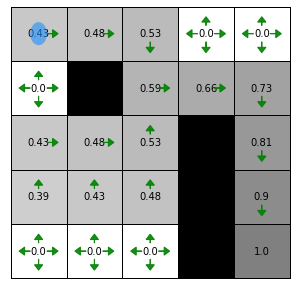

In [232]:
# visualize your results
%matplotlib inline

m.new_render()
m.render(Qlist[-1], policy_list[-1])